## Price Optimization for Products across different categories

Formulated pricing optimization model with Gurobi, segmenting 800 similar items into 2 price-based categories


Developed a predictive model using Gradient boosting to predict sales with price with 82% accuracy


Integrated predictive model into optimization model by Gurobi ML package, ensuring optimal price & quantity

In [3]:
%pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 82.6 MB/s eta 0:00:00


In [4]:
import gurobipy as gp
from gurobipy import GRB

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn import tree

warnings.filterwarnings("ignore")

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate

In [8]:
# saving the dataframe
df = pd.read_csv('product_pricing_data.csv')
df

,Unnamed: 0,p[1],p[2],n[1]
0,0,356.12,197.67,108.0
1,1,358.05,189.68,66.0
2,2,340.79,260.35,130.0
3,3,353.76,133.53,55.0
4,4,341.37,229.80,91.0
...,...,...,...,...
995,995,357.63,241.54,68.0
996,996,352.58,212.95,87.0
997,997,355.28,189.50,94.0
998,998,369.75,166.33,51.0


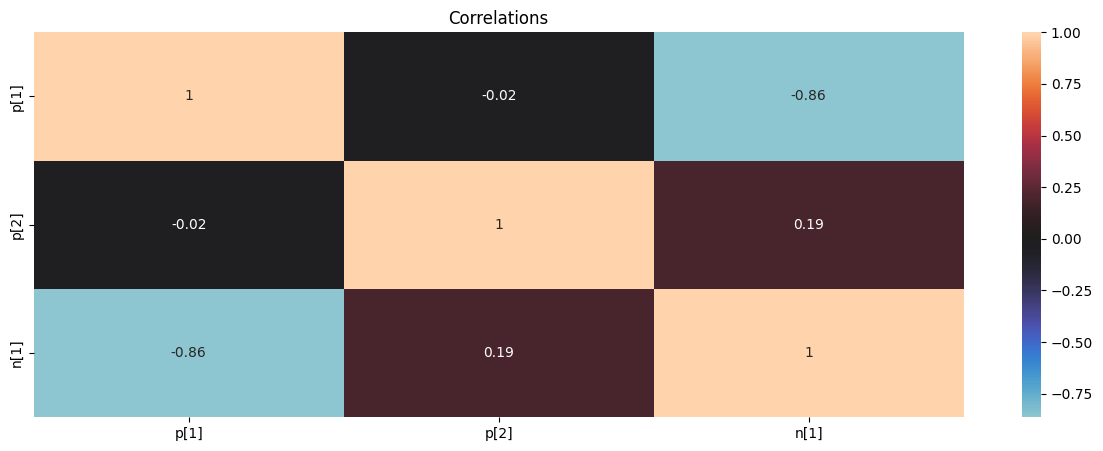

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.heatmap(df[['p[1]','p[2]','n[1]']].corr(),annot=True, center=0,ax=axes)

axes.set_title('Correlations')
plt.show()

In [ ]:
X = df[["p[1]","p[2]"]]
y = df["n[1]"]
# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)

In [ ]:
linear_regressor = make_pipeline(LinearRegression())
linear_regressor.fit(X_train, y_train)
linear_regression_validation = cross_validate(linear_regressor, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

linear_regression_validation['train_score'],linear_regression_validation['test_score']

(array([0.8042117 , 0.79991731, 0.78989955, 0.78789996, 0.78787768]),
 array([0.75322365, 0.76333862, 0.80776284, 0.81689871, 0.8159853 ]))

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
xgb_regressor = make_pipeline(GradientBoostingRegressor(n_estimators=10))
xgb_regressor.fit(X_train, y_train)
xgb_regressor_validation = cross_validate(xgb_regressor, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

xgb_regressor_validation['train_score'], xgb_regressor_validation['test_score']


(array([0.70686285, 0.70108509, 0.69468191, 0.69114426, 0.69192744]),
 array([0.63404923, 0.6889158 , 0.67300186, 0.67788113, 0.66658436]))

In [ ]:
#### Initialize the model
m = gp.Model("price optimization")
products = [1,2]            #### Category 1 and Category 2
N = 800                     #### limit on available space
l = 0                       #### price control, we'll start this at 0

In [ ]:
p = m.addVars(products, name="p")
n = m.addVars(products, name="n")
min_items = {1:50,2:50}
price_bounds = {1:[300,400], 2:[100,300]}
m.addConstrs(n[c] >= min_items[c] for c in products)        #### we could hardcode 50 instead of min_items, but this is more flexible
m.addConstr(p[1] == [300,400])                              #### this is a shorthand way to code 300 <= p[1] <= 400
m.addConstr(p[2] == [100,300]);
m.addConstr(n.sum() ==  N);     #### remember we set N = 200 earlier
m.addConstr(p[1]-p[2] == [50,100]);

In [ ]:
income = gp.quicksum(p[c]*n[c] for c in products)          #### you could also use the more simple p.prod(n)
penalty = l*(p[1]**2+p[2]**2)                               #### we used l as the lambda parameter earlier
m.setObjective(income - penalty, sense = GRB.MAXIMIZE)

In [ ]:
%pip install gurobi-machinelearning
from gurobi_ml import add_predictor_constr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.8/70.8 kB 3.1 MB/s eta 0:00:00


In [ ]:
m_feats = pd.DataFrame({"p[1]":[p[1]],"p[2]":[p[2]]})
m_feats

,p[1],p[2]
0,<gurobi.Var *Awaiting Model Update*>,<gurobi.Var *Awaiting Model Update*>


In [ ]:
pred_constr = add_predictor_constr(m, xgb_regressor, m_feats, n[1])
pred_constr.print_stats()

Model for pipe:
90 variables
11 constraints
244 general constraints
Input has shape (1, 2)
Output has shape (1, 1)

Pipeline has 1 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
gbtree_reg            (1, 1)           90           11            0          244

--------------------------------------------------------------------------------


In [ ]:
m.Params.NonConvex = 2
m.optimize()

Set parameter NonConvex to value 2
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 21 rows, 107 columns and 108 nonzeros
Model fingerprint: 0xb653b676
Model has 2 quadratic objective terms
Model has 244 general constraints
Variable types: 27 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 2e+02]
  RHS range        [1e+00, 8e+02]
  GenCon rhs range [2e-01, 4e+02]
  GenCon coe range [1e+00, 1e+00]
Presolve added 76 rows and 34 columns
Presolve time: 0.03s
Presolved: 102 rows, 144 columns, 365 nonzeros
Presolved model has 68 SOS constraint(s)
Presolved model has 2 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 76 continuous, 68

In [ ]:
print("\nOptimal price for the two categories:\n",round(p[1].X,2),round(p[2].X,2))
print("\nOptimal number of space assigned to the two categories:\n",round(n[1].X), round(n[2].X))
print("\nTotal revenue:\n",round(revenue.getValue(),2))


Optimal price for the two categories:
 381.49 300.0

Optimal number of space assigned to the two categories:
 72 728

Total revenue:
 245864.89
